# Minecraft Creeper

In [2369]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import random
from IPython.display import clear_output


device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Running {torch.__version__} on {device}")

Running 2.3.0 on cpu


## Data Generation
Here, we will generate real images of a Minecraft creeper with some random noise for sake of augmentation. We do not add any other image type in our data distribution due to lack of data for time being.

In [2370]:
X = 0.8

# VAR = [
#     [X, 0, 0],
#     [0, X, 0],
#     [0, 0, X],
#     [X, X, 0],
#     [0, X, X],
#     [X, 0, X]
# ]
m = 200
def generate():
    G = [0,X,0]
    B = [0,0,0]
    # R = [0.5,0,0]
    # G[color] = X
    idx = random.randint(0,5)
    # idx = 1
    # G = [random.uniform(0,0.8),random.uniform(0,0.8),random.uniform(0,0.8)]
    # G = VAR[idx]
    noise = np.array([[random.uniform(0, 0.2),random.uniform(0, 0.2),random.uniform(0, 0.2)] for i in range(64)])
    data = np.array(
    [
        G, G, G, G, G, G, G, G,
        G, B, B, G, G, B, B, G,
        G, B, B, G, G, B, B, G,
        G, G, G, B, B, G, G, G,
        G, G, B, B, B, B, G, G,
        G, G, B, B, B, B, G, G,
        G, G, B, G, G, B, G, G,
        G, G, G, G, G, G, G, G
    ]
    )

    return data+noise

In [2371]:
def sample_real(m=100):
    return np.array([generate() for _ in range(m)])

X_train = torch.from_numpy(np.reshape(sample_real(m), (m, 192))).to(device=device).type(torch.float)

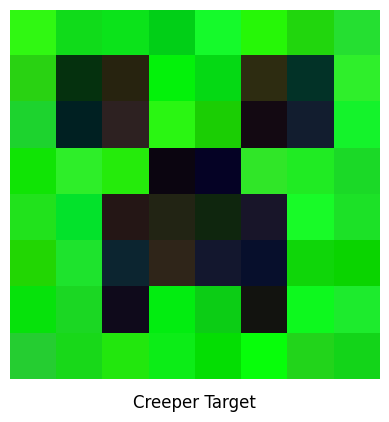

In [2382]:
def display(X, caption):
    plt.imshow(np.reshape(X, (8,8,3)))
    plt.axis('off')
    plt.title(caption,y=-0.1)
    plt.show()

display(generate(), "Creeper Target")

## Model Generation
We will now build our `discriminator` and `generator` models for implementing `GAN`.

In [2383]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=192, out_features=128)
        self.layer2 = nn.Linear(in_features=128, out_features=64)
        # self.layer3 = nn.Linear(in_features=128, out_features=64)
        # self.layer4 = nn.Linear(in_features=64, out_features=32)
        self.layer5 = nn.Linear(in_features=64, out_features=32)
        self.layer6 = nn.Linear(in_features=32, out_features=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        z = self.layer1(x)
        z = self.relu(z)
        z = self.layer2(z)
        z = self.relu(z)
        # z = self.layer3(z)
        # z = self.relu(z)
        # z = self.layer4(z)
        # z = self.relu(z)
        z = self.layer5(z)
        z = self.relu(z)
        z = self.layer6(z)
        z = self.sigmoid(z)
        return z

In [2384]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=3, out_features=12)
        self.layer2 = nn.Linear(in_features=12, out_features=32)
        self.layer3 = nn.Linear(in_features=32, out_features=64)
        self.layer4 = nn.Linear(in_features=64, out_features=192)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        z = self.layer1(x)
        z = self.relu(z)
        z = self.layer2(z)
        z = self.relu(z)
        z = self.layer3(z)
        z = self.relu(z)
        z = self.layer4(z)
        z = self.sigmoid(z)

        return z

Now, we instantiate the models

In [2385]:
discriminator_model = Discriminator().to(device=device)
generator_model = Generator().to(device=device)

print(discriminator_model)
print(generator_model)

Discriminator(
  (layer1): Linear(in_features=192, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=64, bias=True)
  (layer5): Linear(in_features=64, out_features=32, bias=True)
  (layer6): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)
Generator(
  (layer1): Linear(in_features=3, out_features=12, bias=True)
  (layer2): Linear(in_features=12, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=64, bias=True)
  (layer4): Linear(in_features=64, out_features=192, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


#### Inferences
Now let's have a look at what currently the `generator_model` creates.

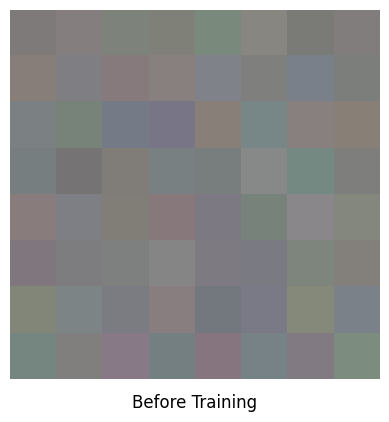

In [2386]:
with torch.inference_mode():
    current_generation = generator_model(torch.randn(3))
    display(np.reshape(current_generation, (8,8,3)), "Before Training")

## Training Process
We will now train our models based on evaluating the solution to
$$
\min_G\max_D V(D,G) = \mathbb E_{x\sim p_{\text{data}}(x)}[\log D(x)] + \mathbb E_{z\sim p_g(z)}[\log(1 - D(G(z)))]
$$

#### Optimizers

In [2387]:
disc_opt = torch.optim.Adam(params=discriminator_model.parameters(), lr = 3e-4)
gene_opt = torch.optim.Adam(params=generator_model.parameters(), lr = 3e-4)

#### Cost Functions

In [2388]:
def loss_discriminator(preds, target):
    return -torch.mean(torch.log(torch.abs(target - 1) + (-1)**torch.abs(target - 1) * preds))*2

def loss_generator(preds):
    return torch.mean(torch.log(1 - preds))

loss_d = nn.BCELoss()

### Sampling Functions

In [2389]:
def sample_generator_data(m=100):
    noise_vectors = torch.from_numpy(np.random.normal(0, 1, (m,3))).to(device=device).type(torch.float)
    with torch.inference_mode():
        model_output = generator_model(noise_vectors)
    return model_output, noise_vectors

def get_data(m=100):
    generator_samples, noise_vectors = sample_generator_data(m)
    data_labels = []
    data_train = []
    for i in range(2*m):
        data_labels.append(1)
        data_train.append(X_train[i//2])

        data_labels.append(0)
        data_train.append(generator_samples[i//2])
        i+=1
    return {"train": torch.stack(data_train), "labels": torch.tensor(data_labels).unsqueeze(1).type(torch.float), "fake": noise_vectors}

### Metrics

In [2390]:
def disc_accuracy(X_train, Y_train):
    with torch.inference_mode():
        y_preds = discriminator_model(X_train)
        correct=torch.eq(torch.round(y_preds),Y_train).sum().item()
        return (correct/len(y_preds))*100

disc_cost = []
gene_cost = []
disc_acc = []

temp = get_data(m)
acc = disc_accuracy(temp["train"], temp["labels"])
print(f"Pre training accuracy of discriminator is {acc} %")

Pre training accuracy of discriminator is 50.0 %


## Training the networks
We will now train our GAN network

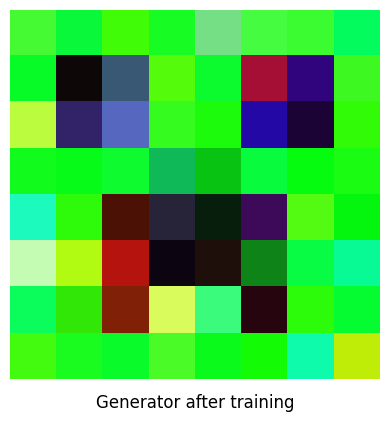

In [2391]:
epochs = 10
steps = 75
train_data = get_data(m)
for i in range(epochs):
    
    for k in range(steps//2):
        discriminator_model.train()

        Y_pred = discriminator_model(train_data["train"])
        loss_disc = loss_discriminator(Y_pred, train_data["labels"])
        # loss_disc = loss_d(Y_pred, train_data["labels"])
        
        disc_opt.zero_grad()
        loss_disc.backward()
        disc_opt.step()
        discriminator_model.eval()

    if i%1 == 0:
        loss_gene = loss_generator(generated_prob)
        gene_cost.append(loss_gene.cpu().detach().numpy())
        loss_disc = loss_discriminator(discriminator_model(train_data["train"]), train_data["labels"])
        # loss_disc = loss_d(Y_pred, train_data["labels"])
        disc_cost.append(loss_disc.cpu().detach().numpy())
        acc = disc_accuracy(train_data["train"], train_data["labels"])
        disc_acc.append(acc)
        # print(f"Training accuracy on {i}th iteration: {acc}")
    
    for _ in range(steps):
        generator_model.train()
        fake_img = generator_model(train_data["fake"])

        generated_prob = discriminator_model(fake_img)

        loss_gene = loss_generator(generated_prob)
        gene_opt.zero_grad()
        loss_gene.backward()
        gene_opt.step()
        generator_model.eval()
        with torch.inference_mode():
            noise = torch.from_numpy(np.random.normal(0, 1, (3))).to(device=device).type(torch.float)
            output = generator_model(noise)
            plt.imshow(np.reshape(output, (8, 8, 3)))
            plt.axis('off')
            plt.title("Generator after training", y=-0.1)
            plt.show()
            clear_output(wait=True)
    train_data = get_data(m)
    if i%1 == 0:
        loss_gene = loss_generator(generated_prob)
        gene_cost.append(loss_gene.cpu().detach().numpy())
        loss_disc = loss_discriminator(discriminator_model(train_data["train"]), train_data["labels"])
        # loss_disc = loss_d(Y_pred, train_data["labels"])
        disc_cost.append(loss_disc.cpu().detach().numpy())
        acc = disc_accuracy(train_data["train"], train_data["labels"])
        disc_acc.append(acc)
        # print(f"Training accuracy on {i}th iteration: {acc}")

Let us now visualize the costs of the models over iterations along with the discriminator's accuracy which should ideally tend towards 50%.

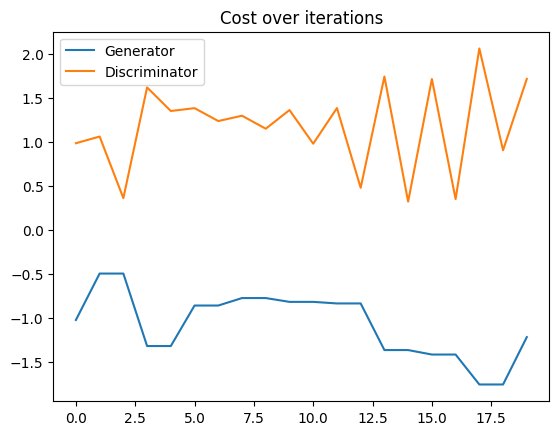

In [2392]:
plt.plot(np.array(gene_cost),label="Generator")
plt.plot(np.array(disc_cost),label="Discriminator")
plt.legend()
plt.title("Cost over iterations")
plt.show()

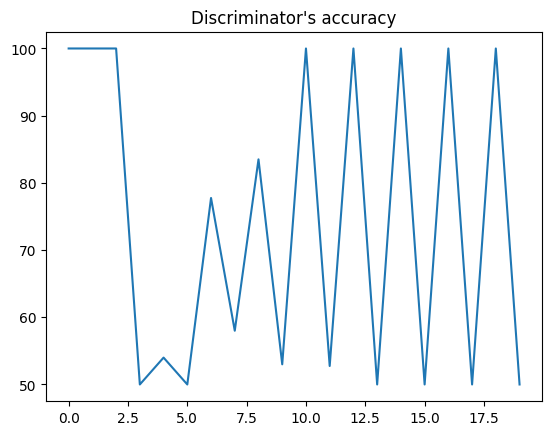

In [2393]:
plt.plot(disc_acc)
plt.title("Discriminator's accuracy")
plt.show()

## Inferences
Let us now look at what the model learnt

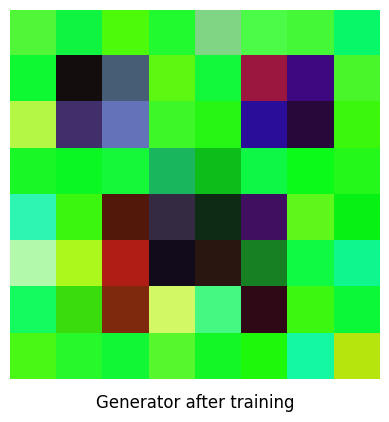

In [2416]:
with torch.inference_mode():
    noise = torch.from_numpy(np.random.normal(0, 1, (3))).to(device=device).type(torch.float)
    output = generator_model(noise)
    display(output, "Generator after training")